In [1]:
# use nx to create topology graph
import networkx as nx

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from dfederation import SKNode, get_data, FederatedCommunity

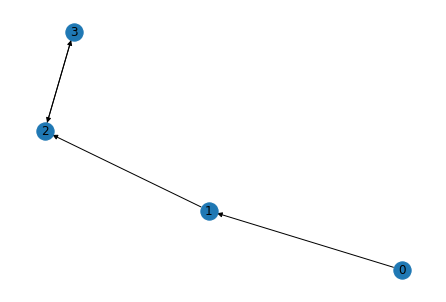

In [19]:
# create a funky topology:

topo = nx.DiGraph()

topo.add_edge(0, 1)
topo.add_edge(1, 2)
topo.add_edge(2, 3)
topo.add_edge(3, 2)

for node in topo.nodes:
    model = linear_model.SGDClassifier()
    topo.nodes[node]['node'] = SKNode(
        model=model, 
        labels=list(range(10)), 
        node_id=node,
    )

nx.draw(topo, with_labels=True)

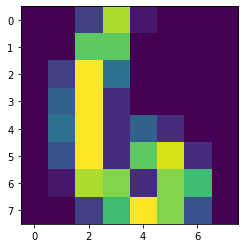

In [20]:
# Get dataset (MNIST):
X_train, X_test, y_train, y_test = train_test_split(
    get_data()['images'], get_data()['target'], 
    test_size=0.2, shuffle=True, random_state=42
)

import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [21]:
comm = FederatedCommunity(topo)

X_train_raveled = [x.ravel() for x in X_train]
X_test_raveled = [x.ravel() for x in X_test]

for node_id in topo.nodes:
    comm.train(X_train_raveled[:2], y_train[:2], node_id)

In [22]:
comm.get_scores(X_test_raveled, y_test)

{0: 0.17777777777777778,
 1: 0.17777777777777778,
 2: 0.17777777777777778,
 3: 0.17777777777777778}

In [23]:
scores_per_node_over_time = []

for batch in range(50):
    comm.train(X_train_raveled[batch*2:(batch+1)*2], y_train[batch*2:(batch+1)*2], 1)
    comm.communicate(times=4)
    scores_per_node_over_time.append(comm.get_scores(X_test_raveled, y_test))

    # SUPER GOOFTOWN:
    if batch % 5 == 1:
        comm.add_edge(3, 0)
    elif batch % 5 == 2:
        comm.remove_edge(3, 0)

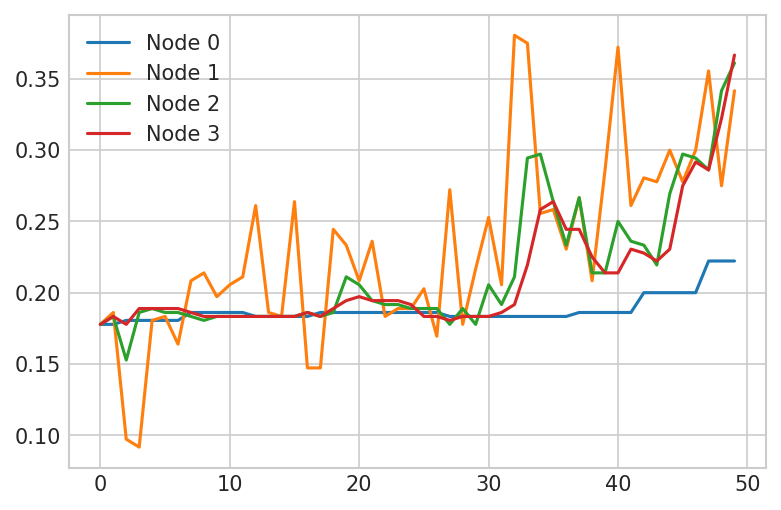

In [24]:
# Plot the scores over time. Each node gets its own line.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4), dpi=150)
    for node_id in scores_per_node_over_time[0]:
        plt.plot(
            [scores_per_node_over_time[i][node_id] for i in range(len(scores_per_node_over_time))],
            label=f"Node {node_id}"
        )
    plt.legend()